# Credit Card Fraud Detection — SMOTE Pipelines & XGBoost

## This Notebook: 
1) Compare cost-sensitive learning vs SMOTE 
2) Train XGBoost with `scale_pos_weight`
3) Compare models using PR-AUC + threshold-tuned metrics

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

In [2]:
# Load Data + split + preprocess (same as previous notebooks)

DATA_PATH = "../data/raw/creditcard.csv"
df = pd.read_csv(DATA_PATH)

X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scale_cols = ["Time", "Amount"]
pass_cols = [c for c in X.columns if c not in scale_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("scale", RobustScaler(), scale_cols),
        ("pass", "passthrough", pass_cols),
    ],
    remainder="drop",
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Helper Function: Evaluate with out-of-fold probabilities
We'll compute out-of-fold PR-AUC/ROC-AUC on the train set and then evaluate on the test set.

In [3]:
def oof_scores(name, model, X_tr, y_tr):
    oof_proba = cross_val_predict(model, X_tr, y_tr, cv=cv, method="predict_proba")[:, 1]
    pr = average_precision_score(y_tr, oof_proba)
    roc = roc_auc_score(y_tr, oof_proba)
    print(f"{name} | OOF PR-AUC={pr:.4f} | OOF ROC-AUC={roc:.4f}")
    return oof_proba

def pick_threshold_by_f1(y_true, proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    best = (0.5, -1)
    for t in thresholds:
        pred = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
        if f1 > best[1]:
            best = (t, f1)
    return best[0], best[1]

def fit_and_test(name, model, X_tr, y_tr, X_te, y_te, threshold):
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    pred = (proba >= threshold).astype(int)
    print(f"\n=== {name} (threshold={threshold:.2f}) ===")
    print("Test ROC-AUC:", roc_auc_score(y_te, proba))
    print("Test PR-AUC:", average_precision_score(y_te, proba))
    print("Confusion matrix:\n", confusion_matrix(y_te, pred))
    print(classification_report(y_te, pred, digits=4))

## 1) Cost-sensitive Logistic Regression (balanced)

In [4]:
lr_bal = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
])

lr_oof = oof_scores("LogReg balanced", lr_bal, X_train, y_train)
lr_thr, lr_f1 = pick_threshold_by_f1(y_train.values, lr_oof)
print("Chosen threshold (OOF best F1):", lr_thr, "F1:", lr_f1)

fit_and_test("LogReg balanced", lr_bal, X_train, y_train, X_test, y_test, lr_thr)

LogReg balanced | OOF PR-AUC=0.7409 | OOF ROC-AUC=0.9815
Chosen threshold (OOF best F1): 0.99 F1: 0.6974248927038627

=== LogReg balanced (threshold=0.99) ===
Test ROC-AUC: 0.9720996498627588
Test PR-AUC: 0.7189400803258542
Confusion matrix:
 [[56802    62]
 [   15    83]]
              precision    recall  f1-score   support

           0     0.9997    0.9989    0.9993     56864
           1     0.5724    0.8469    0.6831        98

    accuracy                         0.9986     56962
   macro avg     0.7861    0.9229    0.8412     56962
weighted avg     0.9990    0.9986    0.9988     56962



## 2) SMOTE + Logistic Regression 
SMOTE must be applied **inside CV/pipeline** so it only sees training folds.

In [5]:
smote_lr = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

smote_oof = oof_scores("SMOTE + LogReg", smote_lr, X_train, y_train)
smote_thr, smote_f1 = pick_threshold_by_f1(y_train.values, smote_oof)
print("Chosen threshold (OOF best F1):", smote_thr, "F1:", smote_f1)

fit_and_test("SMOTE + LogReg", smote_lr, X_train, y_train, X_test, y_test, smote_thr)

SMOTE + LogReg | OOF PR-AUC=0.7430 | OOF ROC-AUC=0.9788
Chosen threshold (OOF best F1): 0.99 F1: 0.6673448626653102

=== SMOTE + LogReg (threshold=0.99) ===
Test ROC-AUC: 0.9714094064750267
Test PR-AUC: 0.7248828678986963
Confusion matrix:
 [[56795    69]
 [   12    86]]
              precision    recall  f1-score   support

           0     0.9998    0.9988    0.9993     56864
           1     0.5548    0.8776    0.6798        98

    accuracy                         0.9986     56962
   macro avg     0.7773    0.9382    0.8396     56962
weighted avg     0.9990    0.9986    0.9987     56962



## 3) XGBoost (scale_pos_weight)
For extreme imbalance, XGBoost benefits from setting `scale_pos_weight = (#neg / #pos)` on training data, to scale it by the imbalance.

In [6]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    ))
])

xgb_oof = oof_scores("XGBoost", xgb, X_train, y_train)
xgb_thr, xgb_f1 = pick_threshold_by_f1(y_train.values, xgb_oof)
print("Chosen threshold (OOF best F1):", xgb_thr, "F1:", xgb_f1)

fit_and_test("XGBoost", xgb, X_train, y_train, X_test, y_test, xgb_thr)

scale_pos_weight: 577.2868020304569
XGBoost | OOF PR-AUC=0.8338 | OOF ROC-AUC=0.9822
Chosen threshold (OOF best F1): 0.91 F1: 0.8430851063829787

=== XGBoost (threshold=0.91) ===
Test ROC-AUC: 0.9787608170730306
Test PR-AUC: 0.8497707032289651
Confusion matrix:
 [[56845    19]
 [   17    81]]
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8100    0.8265    0.8182        98

    accuracy                         0.9994     56962
   macro avg     0.9049    0.9131    0.9089     56962
weighted avg     0.9994    0.9994    0.9994     56962



## 4) Visualize PR curves 
PR curves are often more informative than ROC curves in imbalanced settings, so we plot one.

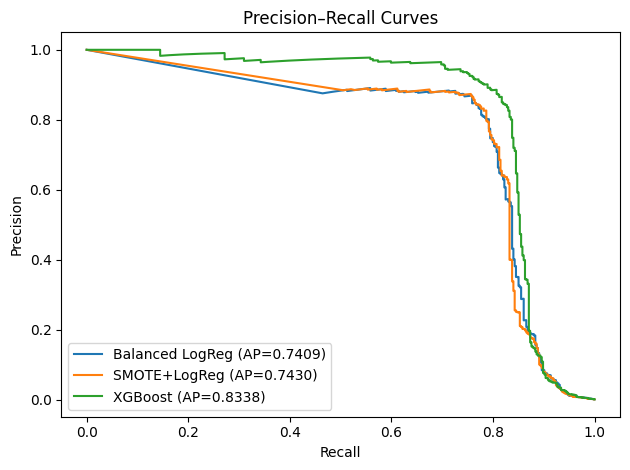

In [8]:
def plot_pr(y_true, proba, label):
    p, r, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    plt.plot(r, p, label=f"{label} (AP={ap:.4f})")

plt.figure()
plot_pr(y_train, lr_oof, "Balanced LogReg")
plot_pr(y_train, smote_oof, "SMOTE+LogReg")
plot_pr(y_train, xgb_oof, "XGBoost")
plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

## 5) Summary Table 

In [9]:
summary = pd.DataFrame({
    "model": ["LogReg balanced", "SMOTE+LogReg", "XGBoost"],
    "OOF_PR_AUC": [
        average_precision_score(y_train, lr_oof),
        average_precision_score(y_train, smote_oof),
        average_precision_score(y_train, xgb_oof)
    ],
    "OOF_ROC_AUC": [
        roc_auc_score(y_train, lr_oof),
        roc_auc_score(y_train, smote_oof),
        roc_auc_score(y_train, xgb_oof)
    ],
    "chosen_threshold": [lr_thr, smote_thr, xgb_thr]
}).sort_values("OOF_PR_AUC", ascending=False)

summary

,model,OOF_PR_AUC,OOF_ROC_AUC,chosen_threshold
2,XGBoost,0.833754,0.982190,0.91
1,SMOTE+LogReg,0.743032,0.978778,0.99
0,LogReg balanced,0.740888,0.981549,0.99
